Generate FEM solution for 2D Poisson problem

* The mesh configuration is fixed to be square given image as input
* Apply both Dirichlet and Neumann boundary conditions for irregular geometry distribution

In [1]:
from PIL import Image

import meshio
import numpy as np
import matplotlib.pyplot as plt
import gaussian_random_fields as gr
import random
import h5py

In [2]:
datafile = "Ti64_thermal_256x256.h5"
samples = ['G5v', 'G6a', 'Y6v', 'Y6a']
im = Image.open(samples[0]+'_XZ_256.tif')
imarray = np.array(im)/255

In [3]:
def plot_image(img):
    plt.figure()
    im1 = plt.imshow(img)
    plt.axis('off')
    plt.colorbar(im1)

#plot_image(imarray) # note this is the element distribution

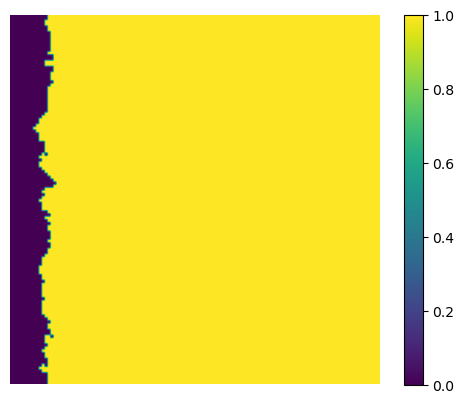

In [4]:
# reduce the size of the image
times = 2
imarray = imarray[::times, ::times]
plot_image(imarray) # note this is the element distribution

(array([ 1577.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 14807.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

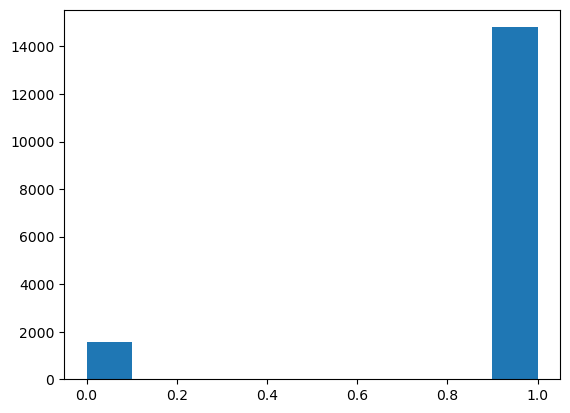

In [5]:
plt.hist(imarray.reshape(-1,1))

In [6]:
def define_dirich_bc(img):
    '''
    Define top/right/bottom boundaries to be Dirichlet boundaries
    '''
    img_node = np.pad(img, ((0,1), (0,1)), 'edge')
    dirich = np.ones_like(img_node) == img_node
    dirich[1:-1,:-1]= False 
    return dirich

In [7]:
def find_surrounding(img, pt):
    '''
    Given a point, return a list of points that are surrounding of current point
    Sequence starts from top left.
    '''
    temp = [[pt[0]-1,pt[1]-1],
            [pt[0]-1,pt[1]],
            [pt[0]-1,pt[1]+1],
            [pt[0],pt[1]-1],
            [pt[0],pt[1]+1],
            [pt[0]+1,pt[1]-1],
            [pt[0]+1,pt[1]],
            [pt[0]+1,pt[1]+1]]
    surrounding = [0, 1, 2, 3, 4, 5, 6, 7]
    dict_surrounding = dict(zip(surrounding, temp))
    h, w = img.shape
    for i, p in enumerate(temp):
        if(p[0] < 0 or p[1] < 0 or p[0] >= h or p[1] >= w):
            del dict_surrounding[i]
    return dict_surrounding

In [8]:
def define_neumann_bc(img):
    '''
    Define left boundary to be Neumann, also need to define connection
    The node id is arranged by row-first approach
    '''
    h_img, w_img = img.shape
    neumann = np.zeros((h_img+1, w_img+1))
    neumann_conn = []
    for i in range(h_img):
        for j in range(w_img):
            if(img[i,j]==1): # if there is material in current pixel i, j
                surrounding = find_surrounding(img, [i,j]) # surrounding pixels
                for key in surrounding: 
                    pt = surrounding[key]
                    if(img[pt[0],pt[1]]==0):
                        if(key == 0):
                            neumann[i,j] = 1
                        if(key == 1):
                            neumann[i,j] = 1
                            neumann[i,j+1] = 1
                            neumann_conn.append([
                                i*(w_img+1)+j,i*(w_img+1)+j+1
                            ]) # generate a connection
                        if(key == 2):
                            neumann[i,j+1] = 1
                        if(key == 3):
                            neumann[i,j] = 1
                            neumann[i+1,j] = 1
                            neumann_conn.append([
                                i*(w_img+1)+j,(i+1)*(w_img+1)+j
                            ]) # generate a connection
                        if(key == 4):
                            neumann[i,j+1] = 1
                            neumann[i+1,j+1] = 1
                            neumann_conn.append([
                                i*(w_img+1)+j+1,(i+1)*(w_img+1)+j+1
                            ]) # generate a connection
                        if(key == 5):
                            neumann[i+1,j] = 1
                        if(key == 6):
                            neumann[i+1,j] = 1
                            neumann[i+1,j+1] = 1
                            neumann_conn.append([
                                (i+1)*(w_img+1)+j,(i+1)*(w_img+1)+j+1
                            ]) # generate a connection
                        if(key == 7):
                            neumann[i+1,j+1] = 1

    return neumann, neumann_conn

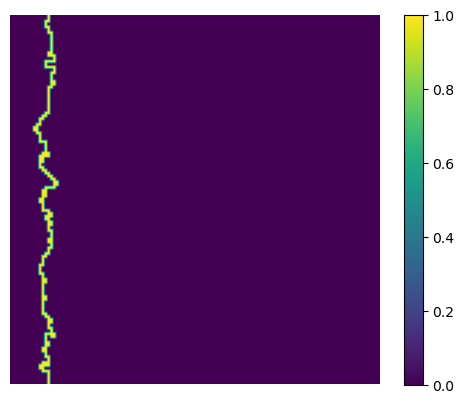

In [9]:
neumann, neumann_conn = define_neumann_bc(imarray)
plot_image(neumann)

### Redefine the problem

In [10]:
'''
n = 2**3
imarray = np.ones((n, n))

# redefine the neumann boundary 
img_node = np.pad(imarray, ((0,1), (0,1)), 'edge')
node_list = np.arange(img_node.shape[0]*img_node.shape[1])
neumann_bc = np.zeros_like(img_node, dtype=bool) 
neumann_bc[:,0]= True
neumann_node = node_list[neumann_bc.reshape(-1).tolist()]
neumann_conn = np.stack((neumann_node[:-1],neumann_node[1:]), axis=-1)
'''

"\nn = 2**3\nimarray = np.ones((n, n))\n\n# redefine the neumann boundary \nimg_node = np.pad(imarray, ((0,1), (0,1)), 'edge')\nnode_list = np.arange(img_node.shape[0]*img_node.shape[1])\nneumann_bc = np.zeros_like(img_node, dtype=bool) \nneumann_bc[:,0]= True\nneumann_node = node_list[neumann_bc.reshape(-1).tolist()]\nneumann_conn = np.stack((neumann_node[:-1],neumann_node[1:]), axis=-1)\n"

In [11]:
class MeshSquareFEM():
    """ 
    Handle a simple square mesh with quad elements
    Given input of image, boundary nodes, and connections
    """

    def __init__(self, hsize, img, dirich_bc, neumann_bc, neumann_conn, outfile = None):
        self.hsize = hsize
        self.img_h, self.img_w = img.shape
        self.dirich_bc = dirich_bc # 2D map, Dirichlet bc nodes are 1
        self.neumann_bc = neumann_bc
        self.neumann_conn = neumann_conn
        self.points, self.cells = self.generate_mesh(img)
        self.generate_node_index()
        
        if outfile is not None:
            self.save_mesh(outfile)

    def generate_mesh(self, img):
        x = np.linspace(0,self.hsize * self.img_w,self.img_w+1, dtype=np.float32)
        y = np.linspace(0,self.hsize * self.img_h,self.img_h+1, dtype=np.float32)
        ms_x, ms_y = np.meshgrid(x,y)
        x = np.ravel(ms_x).reshape(-1,1)
        y = np.ravel(ms_y).reshape(-1,1)
        z = np.zeros_like(x, dtype=np.float32)
        points = np.concatenate((x,y,z),axis=1)
        n_element = self.img_h * self.img_w
        nodes = np.linspace(0,points.shape[0],points.shape[0],endpoint=False,dtype=int).reshape(self.img_h+1,self.img_w+1)
        cells = np.zeros((n_element,4),dtype=int)
        cells[:,0] = np.ravel(nodes[:self.img_w,:self.img_h])
        cells[:,1] = np.ravel(nodes[:self.img_w,1:])
        cells[:,2] = np.ravel(nodes[1:,1:])
        cells[:,3] = np.ravel(nodes[1:,:self.img_h])
        has_element = img > 0.5 # elements that occupied by materials
        cells = cells[has_element.reshape(-1)]
        self.mesh = meshio.Mesh(points, [("quad",cells)]) # generate a mesh used for output
        return points, cells
    
    def generate_node_index(self):
        self.node_list = np.arange((self.img_h+1)*(self.img_w+1))
        self.valid_node = np.unique(self.cells.reshape(-1))
        self.nonvalid_node = np.setdiff1d(self.node_list,self.valid_node)

        self.dirich_node = self.node_list[self.dirich_bc.reshape(-1)]
        self.dirich_plus_nonvalid_node = np.concatenate((self.dirich_node,self.nonvalid_node))
        self.ndirich_valid_node = np.setdiff1d(self.valid_node,self.dirich_node)

    def shapefunc(self, p):
        # shape function
        N = 0.25*np.array([[(1-p[0])*(1-p[1])],
                           [(1+p[0])*(1-p[1])],
                           [(1+p[0])*(1+p[1])],
                           [(1-p[0])*(1+p[1])]])

        dNdp = 0.25*np.array([[-(1-p[1]), -(1-p[0])],
                              [(1-p[1]), -(1+p[0])],
                              [(1+p[1]), (1+p[0])],
                              [-(1+p[1]), (1-p[0])]])
        return N, dNdp

    def save_mesh(self,outfile = 'mesh_square.vtk'):
        self.mesh.write(outfile)

In [12]:
class GridFEM():
    '''
    Note: input the mesh grid, material, bc and f values, generate a finite element problem
    '''
    def __init__(self, grid, material, dirich_val, neumann_val, f_val):
        self.grid = grid
        self.mat_map = material
        self.qpts = np.array([[-1, 1, 1, -1], [-1, -1, 1, 1]])/np.sqrt(3) #[2x4], integration points
        self.n_nodes = grid.points.shape[0]
        self.d = np.zeros(self.n_nodes, dtype=np.float32)

        # generate a finite element problem
        self.DirichBC(dirich_val)
        self.UpdateSource(f_val)
        self.NeumannBC(neumann_val)
        self.A, self.A_F, self.A_EF = self.CreateA()

        
    def CreateA(self):
        '''
        Stiffness matrix, return A_F and A_EF
        Subscript E means essential boundary nodes, F means all remaining valid nodes
        ''' 
        A = np.zeros((self.n_nodes,self.n_nodes))
        for i, c in enumerate(self.grid.cells):
            xe = self.grid.points[c,:].T[:2,:] #[2x4]
            D = self.mat_map[i]*np.eye(2)
            Ke = np.zeros((4,4))
            for q in self.qpts.T:
                [_,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                dNdx = np.dot(dNdp, np.linalg.inv(J)) #[4x2]
                B = np.zeros((2,4))
                B[0,:] = dNdx[:,0]
                B[1,:] = dNdx[:,1]
                Ke += np.linalg.det(J)*np.dot(B.T,np.dot(D,B))
            A[np.ix_(c,c)] += Ke
            
        return A, A[np.ix_(self.grid.ndirich_valid_node,self.grid.ndirich_valid_node)], A[np.ix_(self.grid.dirich_plus_nonvalid_node,self.grid.ndirich_valid_node)]

    def UpdateSource(self, f_val = None):
        '''
        Return the rhs internal sourcing term with modification from finite element term
        '''
        self.f = np.zeros_like(f_val, dtype=np.float32)
        for c in self.grid.cells:
            xe = self.grid.points[c,:].T[:2,:] #[2x4]
            fe = np.zeros(4)
            for q in self.qpts.T:
                [N,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                temp = np.linalg.det(J)*np.dot(N,np.dot(N.T,f_val[c])) #[4x1]
                fe += temp
            self.f[c] += fe
    
    def NeumannBC(self, bc_val):
        for c in self.grid.neumann_conn:
            xe = self.grid.points[c,:][:,:2] #[2x2]
            le = np.linalg.norm(xe[1,:]-xe[0,:])
            for q in [1./np.sqrt(3), -1./np.sqrt(3)]:
                N = 0.5*np.array([1-q, 1+q])
                self.f[c] += np.dot(N,np.dot(N.T,bc_val[c]))*le/2 #[2x1]

    def DirichBC(self, bc_val):
        self.d[self.grid.nonvalid_node] = 0.0 # response should be zero at nonvalid nodes
        self.d[self.grid.dirich_node] = bc_val[self.grid.dirich_node]

    def GaussianRF(self, n, a_interval):
        '''
        Only works for a square mesh
        '''
        alpha = random.uniform(2,5)
        a0, a1 = a_interval[0],a_interval[1]
        field = gr.gaussian_random_field(alpha=alpha, size=n, flag_normalize=False)
        f_min, f_max = np.min(field), np.max(field)
        rf = (a1-a0)*(field-f_min)/(f_max-f_min)+a0
        return rf

    def Solve(self):
        '''
        Solve the linear equation system
        '''
        b_F = self.f[self.grid.ndirich_valid_node] - np.dot(self.A_EF.T, self.d[self.grid.dirich_plus_nonvalid_node])
        d_F = np.linalg.solve(self.A_F, b_F)
        self.d[self.grid.ndirich_valid_node] = d_F

    def PlotField(self, field = None):
        '''Default is to plot the solution field'''
        if(field is None):
            field = self.d
        
        field2d = field.reshape((self.grid.img_h+1, self.grid.img_w+1))
        im = plt.imshow(field2d, origin='lower')
        
        plt.axis('off')
        plt.colorbar(im)
        plt.show()

In [13]:
def loading_type1(dirich_bc, neumann_bc):
    '''
    Input: 
        Binary input which indicates the boundary nodes (2D array)

    Output the value of the boundary loadings:
        dirich_val: a list with the size of expanding dirich bc, fixed temperature values
        neumann_val: a list with the size of expanding neumann bc, normal heat flux at the boundary nodes
    '''
    # dirichlet values, set top temperature to be 5, bottom to be 1
    dirich_val = np.zeros_like(dirich_bc, dtype=np.float32)
    dirich_val[-1, :] = 0 # top, bottom, left, right
    dirich_val[0, :] = 2
    #dirich_value[:, 0] = 0
    dirich_val[:, -1] = 1
    dirich_val = dirich_val*dirich_bc

    # define Neumann boundary, set left flux to be 2
    neumann_val = 0.0*neumann_bc

    # define source
    f_val = np.zeros_like(dirich_val, dtype=np.float32)

    return dirich_val.reshape(-1), neumann_val.reshape(-1), f_val.reshape(-1)

In [14]:
def loading_type2(dirich_bc, neumann_bc):
    '''
    Input: 
        Binary input which indicates the boundary nodes (2D array)

    Output the value of the boundary loadings:
        dirich_val: a list with the size of expanding dirich bc, fixed temperature values
        neumann_val: a list with the size of expanding neumann bc, normal heat flux at the boundary nodes
    '''
    # dirichlet values, set top temperature to be 5, bottom to be 1
    dirich_val = 2*dirich_bc

    dirich_val[-1, :] = 0 # top, bottom, left, right
    dirich_val[0, :] = 0
    #dirich_value[:, 0] = 0
    dirich_val[:, -1] = 1

    # define Neumann boundary, set left flux to be 2
    neumann_val = 0.0*neumann_bc

    # define source
    f_val = np.zeros_like(dirich_val, dtype=np.float32)

    return dirich_val.reshape(-1), neumann_val.reshape(-1), f_val.reshape(-1)

In [15]:
# problem setting
n, _ = imarray.shape
hsize = 0.0061*times # mm
material = 1*np.ones_like(imarray).reshape(-1)
dirich_bc = define_dirich_bc(imarray)
neumann_bc, neumann_conn = define_neumann_bc(imarray)

# redefine boundaries
dirich_bc = np.logical_or(dirich_bc,neumann_bc)
neumann_bc = np.zeros_like(neumann_bc)
dirich_val, neumann_val, f_val = loading_type2(dirich_bc, neumann_bc)

In [16]:
# generate a mesh grid
grid = MeshSquareFEM(hsize, imarray, dirich_bc, neumann_bc, neumann_conn, outfile = None)

In [17]:
'''
validpt = grid.cells[:,0]
pt = grid.points[grid.dirich_node]
plt.scatter(pt[:,0],pt[:,1])
plt.xlim([0,1.57])
plt.ylim([0,1.57])
plt.axis('scaled')'''

"\nvalidpt = grid.cells[:,0]\npt = grid.points[grid.dirich_node]\nplt.scatter(pt[:,0],pt[:,1])\nplt.xlim([0,1.57])\nplt.ylim([0,1.57])\nplt.axis('scaled')"

In [18]:
# generate FEM problem
problem = GridFEM(grid, material, dirich_val, neumann_val, f_val)

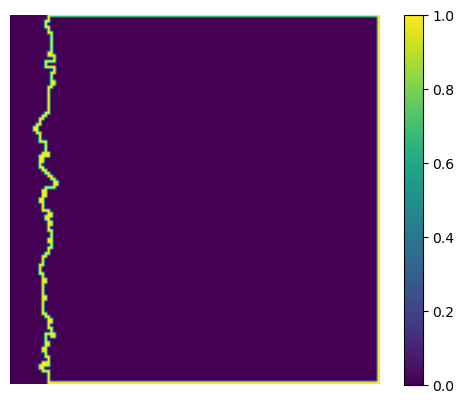

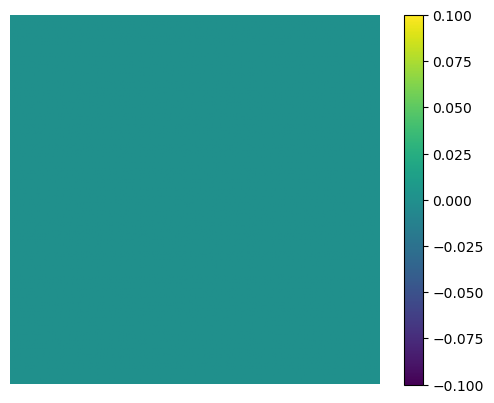

In [19]:
plot_image(dirich_bc)
plot_image(neumann_bc)

In [20]:
'''A_diag = np.diag(problem.A)
zero_diag = np.where(A_diag == 0)[0]
pt = problem.grid.points[grid.valid_node]
plt.scatter(pt[:,0],pt[:,1])
plt.xlim([0,1.57])
plt.ylim([0,1.57])
plt.axis('scaled')'''

"A_diag = np.diag(problem.A)\nzero_diag = np.where(A_diag == 0)[0]\npt = problem.grid.points[grid.valid_node]\nplt.scatter(pt[:,0],pt[:,1])\nplt.xlim([0,1.57])\nplt.ylim([0,1.57])\nplt.axis('scaled')"

In [21]:
'''test_image = np.zeros(((n+1)*(n+1),))
test_image[grid.valid_node] = 1
plt.imshow(test_image.reshape(n+1,n+1))'''

'test_image = np.zeros(((n+1)*(n+1),))\ntest_image[grid.valid_node] = 1\nplt.imshow(test_image.reshape(n+1,n+1))'

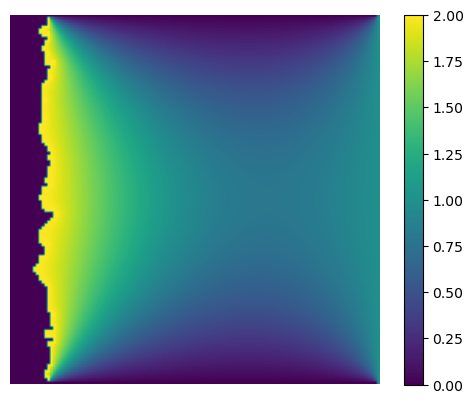

In [22]:
problem.Solve()
problem.PlotField()

In [23]:
# Create dataset
n_data = 1
datafile = "thermal_Ti64.h5"

dataset = {}
dirich_idx_data = np.zeros((n_data, n+1, n+1, 1))
dirich_value_data = np.zeros((n_data, n+1, n+1, 1))
neumann_idx_data = np.zeros((n_data, n+1, n+1, 1))
neumann_value_data = np.zeros((n_data, n+1, n+1, 1))
mask_data = np.zeros((n_data, n+1, n+1, 1))
material_data = np.zeros((n_data, n, n, 1))
f_data = np.zeros((n_data, n+1, n+1))
u_data = np.zeros((n_data, n+1, n+1))
for i in range(n_data):
    dirich_val, neumann_val, f_val = loading_type2(dirich_bc, neumann_bc)
    material = np.ones((n,n,1))
    problem = GridFEM(grid, material.reshape(-1), dirich_val, neumann_val, f_val)
    problem.Solve()
    material_data[i] = material
    dirich_idx_data[i,:,:,0] = 1-dirich_bc
    dirich_value_data[i,:,:,0] = dirich_val.reshape((n+1, n+1))
    neumann_idx_data[i,:,:,0] = neumann_bc
    neumann_value_data[i,:,:,0] = neumann_val.reshape((n+1, n+1))
    f_data[i,:,:] = f_val.reshape((n+1, n+1))
    u_data[i,:,:] = problem.d.reshape((n+1, n+1))
    print("Problem #-"+str(i)+" solved")

    # create mask images
    temp = np.zeros(((n+1)*(n+1),))
    temp[grid.valid_node] = 1
    mask_data[i,:,:,0] = temp.reshape((n+1,n+1))

Problem #-0 solved


In [24]:
dataset['mask'] = mask_data
dataset['dirich_idx'] = dirich_idx_data
dataset['dirich_value'] = dirich_value_data
dataset['neumann_idx'] = neumann_idx_data
dataset['neumann_value'] = neumann_value_data
dataset['material'] = material_data
dataset['source'] = f_data
dataset['solution'] = u_data

with h5py.File(datafile, "w") as hf:
    for key, item in dataset.items():
        hf[key] = item